[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/fonnesbeck/bayes_course_june_2024/blob/master/notebooks/Section4-Hierarchical_Models.ipynb)

# Hierarchical Models in PyMC

Hierarchical or multilevel modeling is a generalization of regression modeling.

*Multilevel models* are regression models in which the constituent model parameters are given **probability models**. This implies that model parameters are allowed to **vary by group**.

Observational units are often naturally **clustered**. Clustering induces dependence between observations, despite random sampling of clusters and random sampling within clusters.

A *hierarchical model* is a particular multilevel model where parameters are nested within one another.

Some multilevel structures are not hierarchical. 

* e.g. "country" and "year" are not nested, but may represent separate, but overlapping, clusters of parameters

For this topic, let's revisit the radon dataset from the first section.


### Example: Radon contamination (Gelman and Hill 2006)

Radon is a radioactive gas that enters homes through contact points with the ground. It is a carcinogen that is the primary cause of lung cancer in non-smokers. Radon levels vary greatly from household to household.

![radon](images/how_radon_enters.jpg)

The EPA did a study of radon levels in 80,000 houses. Two important predictors:

* measurement in basement or first floor (radon higher in basements)
* county uranium level (positive correlation with radon levels)

We will focus on modeling radon levels in Minnesota.

The hierarchy in this example is households within county. 

### Data organization

First, we import the data from a local file, and extract Minnesota's data.

In [1]:
%matplotlib inline
import numpy as np
import polars as pl
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')
import warnings
warnings.filterwarnings("ignore", module="mkl_fft")
warnings.filterwarnings("ignore", module="matplotlib")

DATA_URL = 'https://raw.githubusercontent.com/fonnesbeck/bayes_course_dec_2023/master/data/'

try:
    srrs2 = pl.read_csv('../data/srrs2.dat')
except FileNotFoundError:
    srrs2 = pl.read_csv(DATA_URL + 'srrs2.dat')

# Import radon data

srrs2.columns = [col.strip() for col in srrs2.columns]
srrs_mn = srrs2.filter(pl.col("state")=='MN')

RANDOM_SEED = 20090425

Next, obtain the county-level predictor, uranium, by combining two variables.

In [2]:
try:
    cty = pl.read_csv('../data/cty.dat')
except FileNotFoundError:
    cty = pl.read_csv(DATA_URL + 'cty.dat')

srrs_mn= srrs_mn.with_columns((pl.col("stfips").cast(pl.Float32) * 1000 + pl.col("cntyfips").str.strip_chars().cast(pl.Float32)).alias("fips"))
cty_mn = cty.filter(pl.col("st")=='MN')
cty_mn = cty_mn.with_columns((pl.col("stfips").cast(pl.Float32) * 1000 + pl.col("ctfips").cast(pl.Float32)).alias("fips"))

Use the `merge` method to combine home- and county-level information in a single DataFrame.

In [3]:
srrs_mn = srrs_mn.join(cty_mn[['fips', 'Uppm']], on='fips')
srrs_mn = srrs_mn.unique(subset='idnum')
u = np.log(srrs_mn["Uppm"]).unique().to_numpy()

n = len(srrs_mn)

We also need a lookup table (`dict`) for each unique county, for indexing.

In [4]:
srrs_mn = srrs_mn.with_columns(pl.col("county").str.strip_chars().cast(pl.Categorical))
county = srrs_mn['county'].to_physical().to_numpy()
mn_counties = srrs_mn['county'].cat.get_categories()

Finally, create local copies of variables.

In [5]:
mn_counties.shape

(85,)

In [6]:
srrs_mn = srrs_mn.with_columns(pl.col("activity").str.strip_chars().cast(pl.Float32).alias('radon'))
srrs_mn = srrs_mn.with_columns(np.log(pl.col("radon") + 0.1).alias("log_radon"))
floor_measure = srrs_mn["floor"].to_numpy()

Distribution of radon levels in MN (log scale):

In [7]:
srrs_mn['log_radon'].plot.hist()

:Histogram   [log_radon]   (log_radon_count)

## Conventional approaches

The two conventional alternatives to modeling radon exposure represent the two extremes of the bias-variance tradeoff:

***Complete pooling***: 

Treat all counties the same, and estimate a single radon level.

$$y_i = \alpha + \beta x_i + \epsilon_i$$

***No pooling***:

Model radon in each county independently.

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

where $j = 1,\ldots,85$

The errors $\epsilon_i$ may represent measurement error, temporal within-house variation, or variation among houses.

Here are the point estimates of the slope and intercept for the complete pooling model:

In [8]:
floor = srrs_mn['floor'].to_numpy()
log_radon = srrs_mn['log_radon'].to_numpy()

with pm.Model() as pooled_model:
    
    mu = pm.Normal('mu', 0, sigma=1e5)
    beta = pm.Normal('beta', mu=0, sigma=1e5)
    sigma = pm.HalfCauchy('sigma', 5)
    
    theta = mu + beta*floor
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon)
    

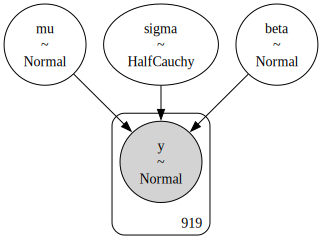

In [9]:
pm.model_to_graphviz(pooled_model)

In [10]:
with pooled_model:
    pooled_trace = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


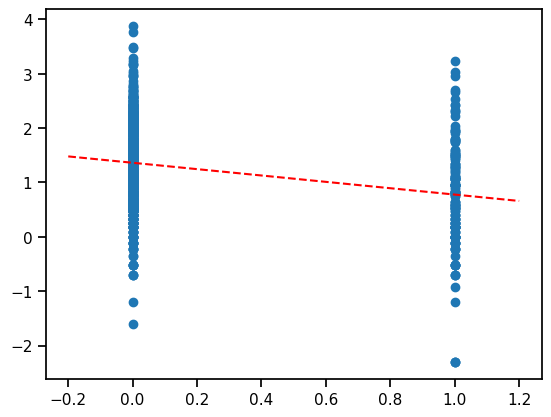

In [11]:
mu_mean = pooled_trace.posterior.mean(dim=("chain", "draw")).mu.values
beta_mean = pooled_trace.posterior.mean(dim=("chain", "draw")).beta.values


plt.scatter(srrs_mn['floor'], srrs_mn['log_radon'])
xvals = np.linspace(-0.2, 1.2)
plt.plot(xvals, beta_mean*xvals + mu_mean, 'r--');

Estimates of county radon levels for the unpooled model:

In [12]:
coords={'county': mn_counties}

with pm.Model(coords=coords) as unpooled_model:
    
    mu = pm.Normal('mu', 0, sigma=1e5, dims='county')
    beta = pm.Normal('beta', 0, sigma=1e5)
    sigma = pm.HalfCauchy('sigma', 5)
    
    theta = mu[county] + beta*floor
    
    y = pm.Normal('y', theta, sigma=sigma, observed=log_radon)
    

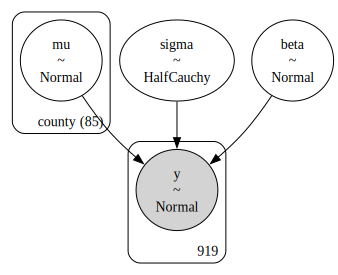

In [13]:
pm.model_to_graphviz(unpooled_model)

In [14]:
with unpooled_model:
    unpooled_trace = pm.sample(random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


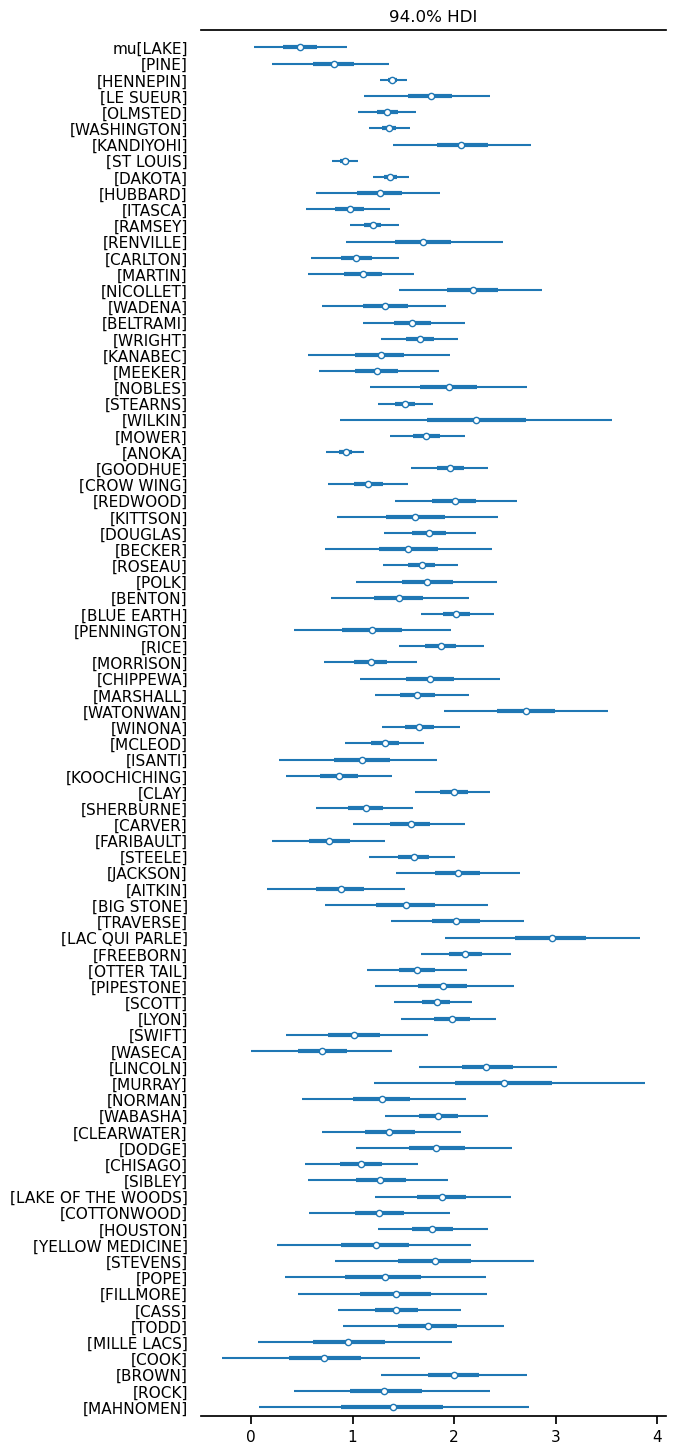

In [15]:
az.plot_forest(
    unpooled_trace, 
    var_names=['mu'], 
    # ess=True, r_hat=True, 
    combined=True,
    figsize=(6,18)
);

In [16]:
unpooled_estimates = unpooled_trace.posterior.mean(dim=('chain', 'draw')).mu
unpooled_se = unpooled_trace.posterior.std(dim=('chain', 'draw')).mu

We can plot the ordered estimates to identify counties with high radon levels:

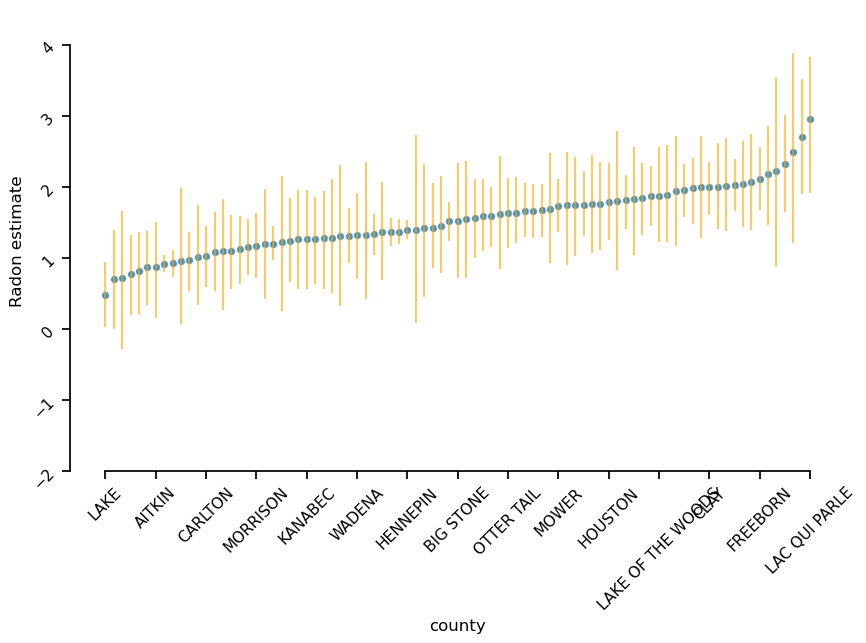

In [17]:
unpooled_means = unpooled_trace.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(unpooled_trace)

unpooled_means_iter = unpooled_means.sortby("mu")
unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter.mu)

_, ax = plt.subplots(figsize=(10,6))
xticks = np.arange(0, 86, 6)
unpooled_means_iter.plot.scatter(x="county", y="mu", ax=ax, alpha=0.8)
ax.vlines(
    np.arange(mn_counties.shape[0]),
    unpooled_hdi_iter.mu.sel(hdi="lower"),
    unpooled_hdi_iter.mu.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
)
ax.set(ylabel="Radon estimate", ylim=(-2, 4.5))
ax.set_xticks(xticks)
ax.set_xticklabels(unpooled_means_iter.county.values[xticks])
ax.tick_params(rotation=45)
sns.despine(trim=True);

Here are visual comparisons between the pooled and unpooled estimates for a subset of counties representing a range of sample sizes.

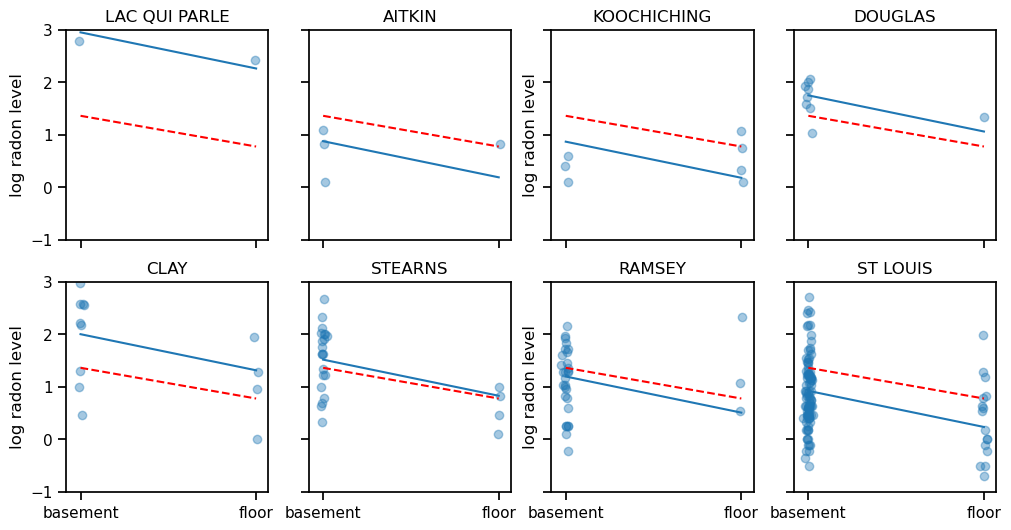

In [18]:
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace.posterior.mean(dim=("chain", "draw")).beta
for i,c in enumerate(sample_counties):
    y, x = srrs_mn.filter(pl.col("county")==c)[["log_radon", "floor"]].to_numpy().T
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    b = unpooled_estimates.sel(county=c)
    
    # Plot both models and data
    xvals = np.linspace(0, 1)
    axes[i].plot(xvals, m.values*xvals+b.values)
    axes[i].plot(xvals, beta_mean*xvals+mu_mean, 'r--')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

Neither of these models are satisfactory:

* if we are trying to identify high-radon counties, pooling is useless
* we do not trust extreme unpooled estimates produced by models using few observations

## Multilevel and hierarchical models

When we pool our data, we imply that they are sampled from the same model. This ignores any variation among sampling units (other than sampling variance):

![pooled](images/pooled_model.png)

When we analyze data unpooled, we imply that they are sampled independently from separate models. At the opposite extreme from the pooled case, this approach claims that differences between sampling units are to large to combine them:

![unpooled](images/unpooled_model.png)

In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***parital pooling***.

![hierarchical](images/partial_pooled_model.png)

We can use PyMC to easily specify multilevel models, and fit them using Markov chain Monte Carlo.

## Partial pooling model

The simplest partial pooling model for the household radon dataset is one which simply estimates radon levels, without any predictors at any level. A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled county estimates and the pooled estimates.

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

Estimates for counties with smaller sample sizes will shrink towards the state-wide average.

Estimates for counties with larger sample sizes will be closer to the unpooled county estimates.

In [19]:
with pm.Model(coords=coords) as partial_pooling:
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    
    # Random intercepts
    mu = pm.Normal('mu', mu=mu_a, sigma=sigma_a, dims='county')
    
    # Model error
    sigma_y = pm.HalfCauchy('sigma_y',5)
    
    # Expected value
    y_hat = mu[county]
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon)
    

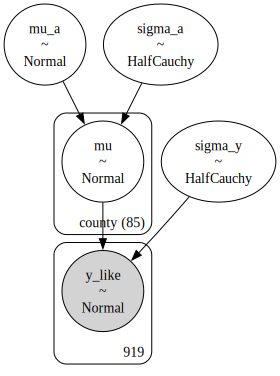

In [20]:
pm.model_to_graphviz(partial_pooling)

In [22]:
with partial_pooling:
    partial_pooling_trace = pm.sample(tune=2000, random_seed=21)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu, sigma_y]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


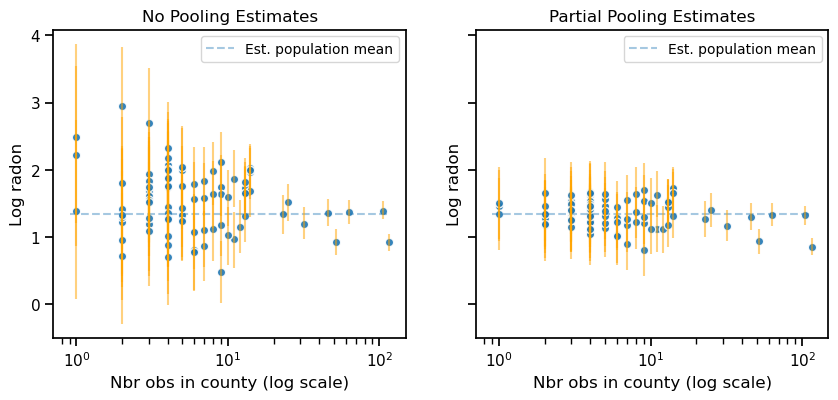

In [23]:
N_county = srrs_mn.group_by("county").agg(pl.col("idnum").count())['idnum'].to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, trace, level in zip(
    axes,
    (unpooled_trace, partial_pooling_trace),
    ("no pooling", "partial pooling"),
):

    # add variable with x values to xarray dataset
    trace.posterior = trace.posterior.assign_coords({"N_county": ("county", N_county)})
    # plot means
    trace.posterior.mean(dim=("chain", "draw")).plot.scatter(
        x="N_county", y="mu", ax=ax, alpha=0.9
    )
    ax.hlines(
        partial_pooling_trace.posterior.mu.mean(),
        0.9,
        max(N_county) + 1,
        alpha=0.4,
        ls="--",
        label="Est. population mean",
    )

    # plot hdi
    hdi = az.hdi(trace).mu
    ax.vlines(N_county, hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), color="orange", alpha=0.5)

    ax.set(
        title=f"{level.title()} Estimates",
        xlabel="Nbr obs in county (log scale)",
        xscale="log",
        ylabel="Log radon",
    )
    ax.legend(fontsize=10)

Notice the difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes. The former are both more extreme and more imprecise.

## Varying intercept model

This model allows intercepts to vary across county, according to a random effect.

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

As with the the “no-pooling” model, we set a separate intercept for each county, but rather than fitting separate least squares regression models for each county, multilevel modeling **shares strength** among counties, allowing for more reasonable inference in counties with little data.

In [24]:
with pm.Model(coords=coords) as varying_intercept:
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e4)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    
    # Random intercepts
    mu = pm.Normal('mu', mu=mu_a, sigma=sigma_a, dims='county')
    # Common slope
    beta = pm.Normal('beta', mu=0., sigma=1e4)
    
    # Model error
    sd_y = pm.HalfCauchy('sd_y', 5)
    
    # Expected value
    y_hat = mu[county] + beta * floor_measure
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sd_y, observed=log_radon)
    

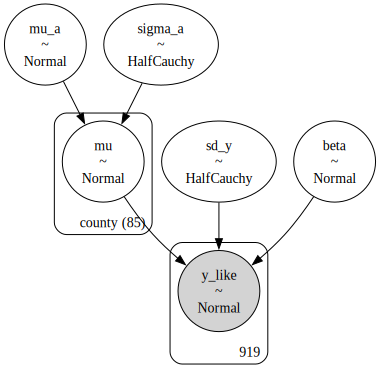

In [25]:
pm.model_to_graphviz(varying_intercept)

In [26]:
with varying_intercept:
    varying_intercept_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu, beta, sd_y]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 3 seconds.


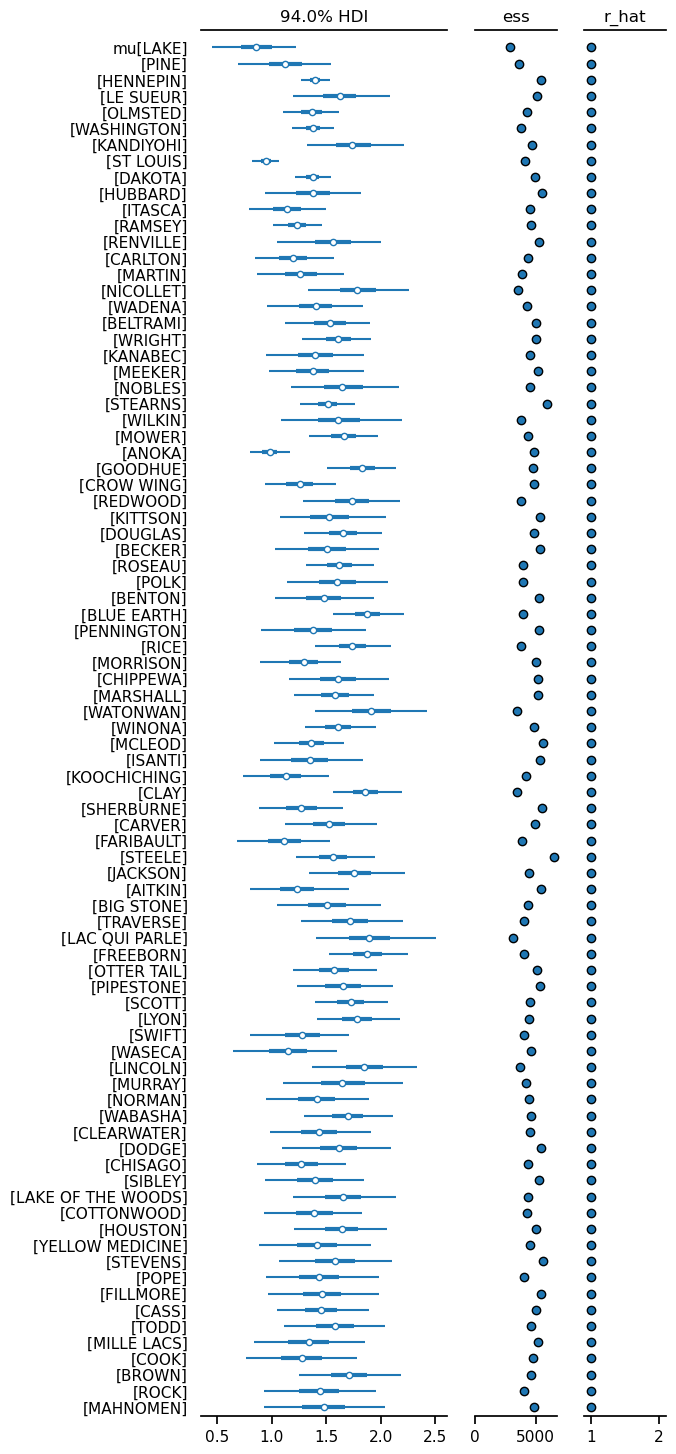

In [27]:
pm.plot_forest(varying_intercept_trace, var_names=['mu'], figsize=(6,18), combined=True, ess=True, r_hat=True);

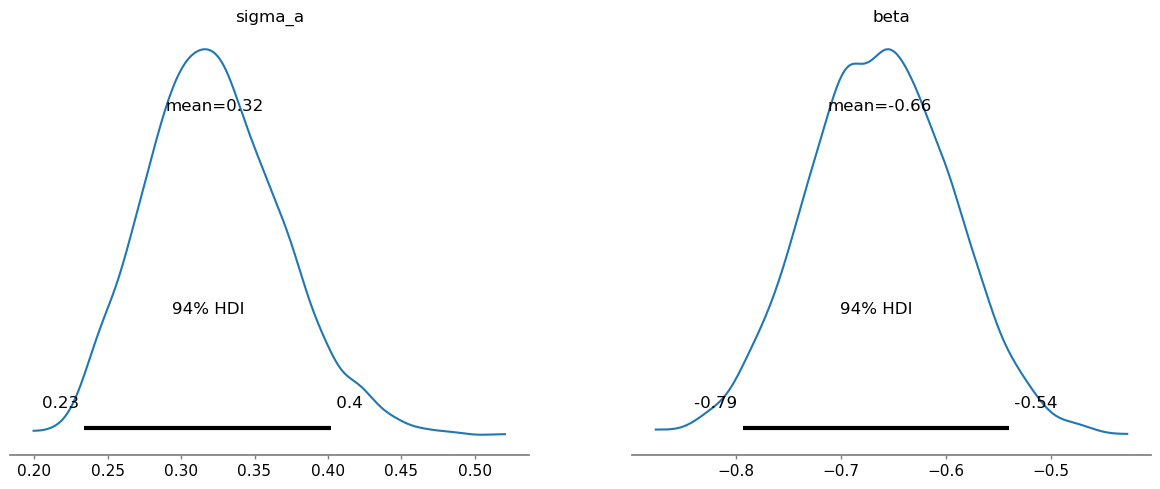

In [28]:
pm.plot_posterior(varying_intercept_trace, var_names=['sigma_a', 'beta']);

The estimate for the `floor` coefficient is approximately -0.66, which can be interpreted as houses without basements having about half ($\exp(-0.66) = 0.52$) the radon levels of those with basements, after accounting for county.

In [29]:
az.summary(varying_intercept_trace, var_names=['beta'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,-0.663,0.068,-0.794,-0.54,0.001,0.001,2856.0,3056.0,1.0


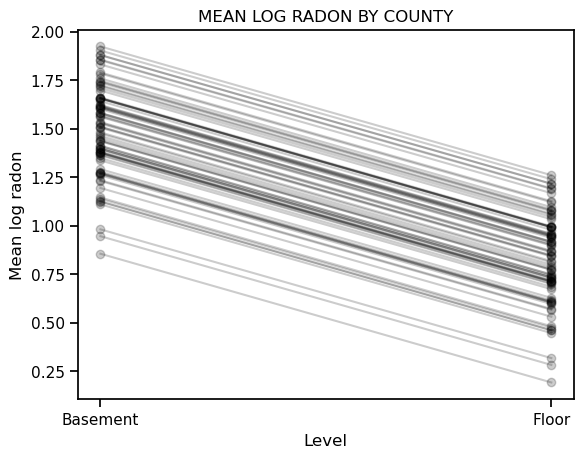

In [30]:
import xarray as xr

xvals = xr.DataArray([0, 1], dims="Level", coords={"Level": ["Basement", "Floor"]})
post = varying_intercept_trace.posterior  # alias for readability
theta = (
    (post.mu + post.beta * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean log radon")
)

_, ax = plt.subplots()
theta.plot.scatter(x="Level", y="Mean log radon", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean log radon"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("MEAN LOG RADON BY COUNTY");

It is easy to show that the partial pooling model provides more objectively reasonable estimates than either the pooled or unpooled models, at least for counties with small sample sizes.

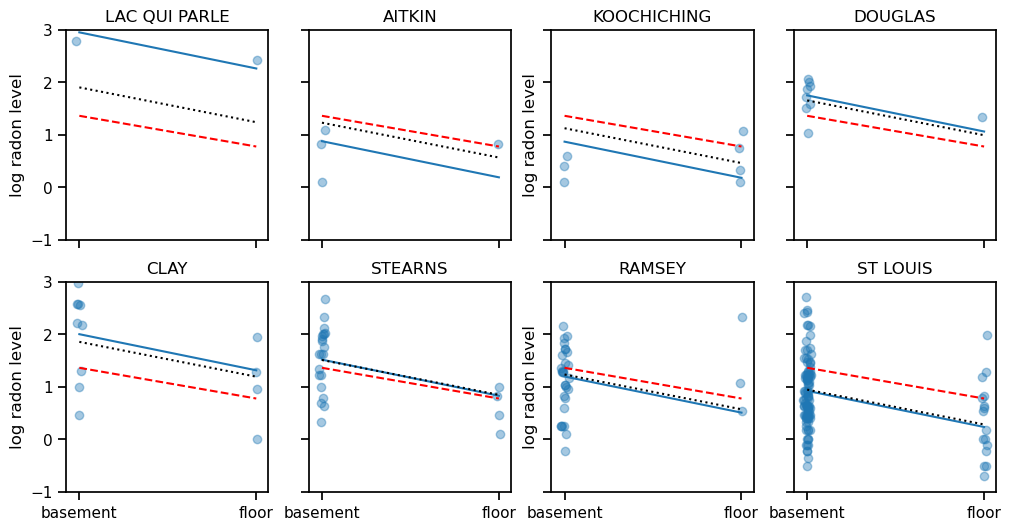

In [31]:
sample_counties = ('LAC QUI PARLE', 'AITKIN', 'KOOCHICHING', 
                    'DOUGLAS', 'CLAY', 'STEARNS', 'RAMSEY', 'ST LOUIS')

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace.posterior.mean(dim=("chain", "draw")).beta
for i,c in enumerate(sample_counties):
    y, x = srrs_mn.filter(pl.col("county")==c)[["log_radon", "floor"]].to_numpy().T
    axes[i].scatter(x + np.random.randn(len(x))*0.01, y, alpha=0.4)
    
    # No pooling model
    b = unpooled_estimates.sel(county=c)
    
    # Plot both models and data
    xvals = np.linspace(0, 1)
    axes[i].plot(xvals, m.values*xvals+b.values)
    axes[i].plot(xvals, beta_mean*xvals+mu_mean, 'r--')
    varying_intercept_trace.posterior.sel(county=c).beta
    post = varying_intercept_trace.posterior.sel(county=c).mean(dim=("chain", "draw"))
    theta = (
        post.mu.values + post.beta.values * xvals
    )
    axes[i].plot(xvals, theta, 'k:')
    axes[i].set_xticks([0,1])
    axes[i].set_xticklabels(['basement', 'floor'])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i%2:
        axes[i].set_ylabel('log radon level')

### Exercise: Varying slope model

Alternatively, we can posit a model that allows the counties to vary according to how the location of measurement (basement or floor) influences the radon reading.

$$y_i = \alpha + \beta_{j[i]} x_{i} + \epsilon_i$$

Construct a model called `varying_slope` thart implements this alternative model.


In [35]:
with pm.Model(coords=coords) as varying_slope:
    
    # Priors
    mu_b = pm.Normal('mu_b', mu=0., sigma=1e4)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    beta = pm.Normal('beta', mu=mu_b, sigma=sigma_b, dims='county')
    mu = pm.Normal('mu', mu=0., sigma=1e4)
    
    # Model error
    sd_y = pm.HalfCauchy('sd_y', 5)
    
    # Expected value
    y_hat = mu + beta[county] * floor_measure
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sd_y, observed=log_radon)

    varying_slope_trace = pm.sample(random_seed=RANDOM_SEED)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b, sigma_b, beta, mu, sd_y]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.
There were 27 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


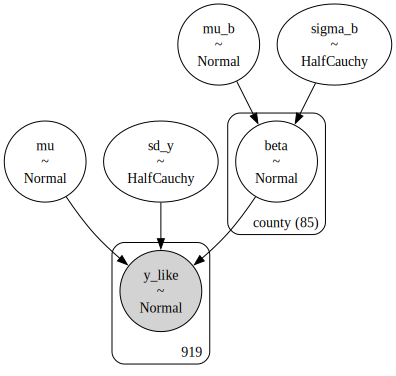

In [38]:
pm.model_to_graphviz(varying_slope)

## Non-centered Parameterization

The partial pooling models specified above uses a **centered** parameterization of the slope random effect. That is, the individual county effects are distributed around a county mean, with a spread controlled by the hierarchical standard deviation parameter. As the preceding plot reveals, this constraint serves to **shrink** county estimates toward the overall mean, to a degree proportional to the county sample size. This is exactly what we want, and the model appears to fit well--the Gelman-Rubin statistics are exactly 1.

But, on closer inspection, there are signs of trouble. Specifically, let's look at the trace of the random effects, and their corresponding standard deviation:

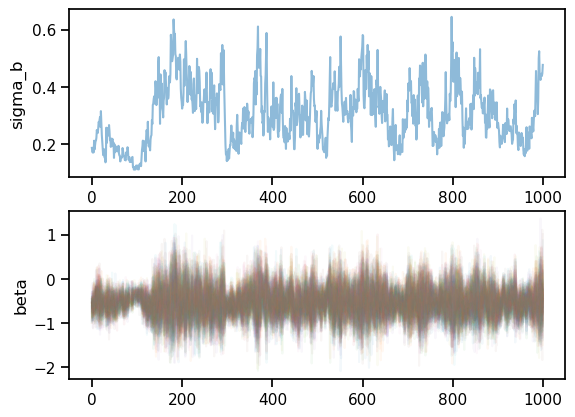

In [36]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(varying_slope_trace.posterior.sel(chain=0)['sigma_b'], alpha=.5);
axs[0].set(ylabel='sigma_b');
axs[1].plot(varying_slope_trace.posterior.sel(chain=0)['beta'], alpha=.05);
axs[1].set(ylabel='beta');

Notice that when the chain reaches the lower end of the parameter space for $\sigma_b$, it appears to get "stuck" and the entire sampler, including the random slopes `b`, mixes poorly. 

Jointly plotting the random effect variance and one of the individual random slopes demonstrates what is going on.

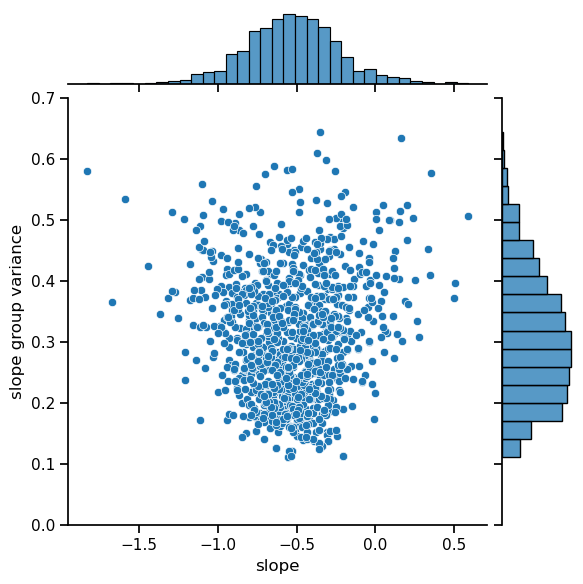

In [37]:
x = varying_slope_trace.posterior['beta'].sel(chain=0, county='AITKIN').to_series() 
x.name='slope'
y = varying_slope_trace.posterior['sigma_b'].sel(chain=0).to_series()
y.name='slope group variance'

jp = sns.jointplot(x=x, y=y, ylim=(0, .7));

When the group variance is small, this implies that the individual random slopes are themselves close to the group mean. This results in a *funnel*-shaped relationship between the samples of group variance and any of the slopes (particularly those with a smaller sample size). 

In itself, this is not a problem, since this is the behavior we expect. However, if the sampler is tuned for the wider (unconstrained) part of the parameter space, it has trouble in the areas of higher curvature. The consequence of this is that the neighborhood close to the lower bound of $\sigma_b$ is sampled poorly; indeed, in our chain it is not sampled at all below 0.1. The result of this will be biased inference.

Now that we've spotted the problem, what can we do about it? The best way to deal with this issue is to reparameterize our model. Notice the random slopes in this version:

In [39]:
with pm.Model(coords=coords) as varying_slope_noncentered:
    
    # Priors
    mu_b = pm.Normal('mu_b', mu=0., sigma=1e5)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    # Common intercepts
    mu = pm.Normal('mu', mu=0., sigma=1e5)
    
    # Non-centered random slopes
    # Centered: b = pm.Normal('b', mu_b, sigma=sigma_b, shape=counties)
    z = pm.Normal('z', mu=0, sigma=1, dims='county')
    beta = pm.Deterministic("beta", mu_b + z * sigma_b, dims='county')
    
    # Model error
    sigma_y = pm.HalfCauchy('sigma_y',5)
    
    # Expected value
    y_hat = mu + beta[county] * floor_measure
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon)
    

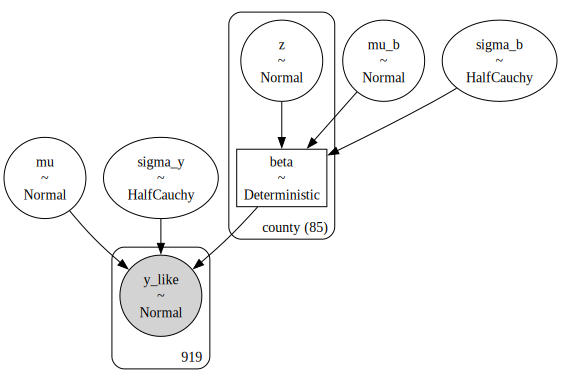

In [40]:
pm.model_to_graphviz(varying_slope_noncentered)

This is a **non-centered** parameterization. By this, we mean that the random deviates are no longer explicitly modeled as being centered on $\mu_b$. Instead, they are independent standard normals $\upsilon$, which are then scaled by the appropriate value of $\sigma_b$, before being location-transformed by the mean.

This model samples much better.

In [41]:
with varying_slope_noncentered:
    noncentered_trace = pm.sample(tune=2000, target_accept=.9, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_b, sigma_b, mu, z, sigma_y]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 6 seconds.


Notice that the bottlenecks in the traces are (mostly) gone.

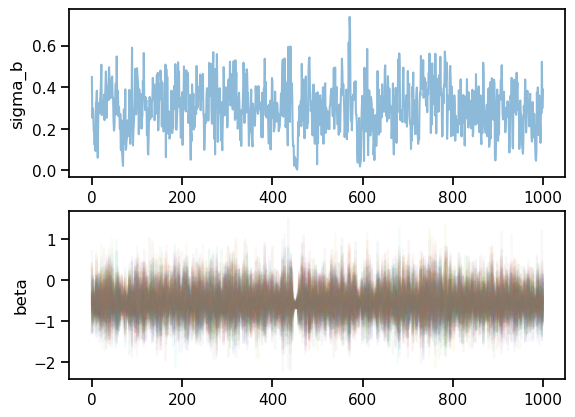

In [42]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(noncentered_trace.posterior.sel(chain=0)['sigma_b'], alpha=.5);
axs[0].set(ylabel='sigma_b');
axs[1].plot(noncentered_trace.posterior.sel(chain=0)['beta'], alpha=.05);
axs[1].set(ylabel='beta');

And, we are now fully exploring the support of the posterior.

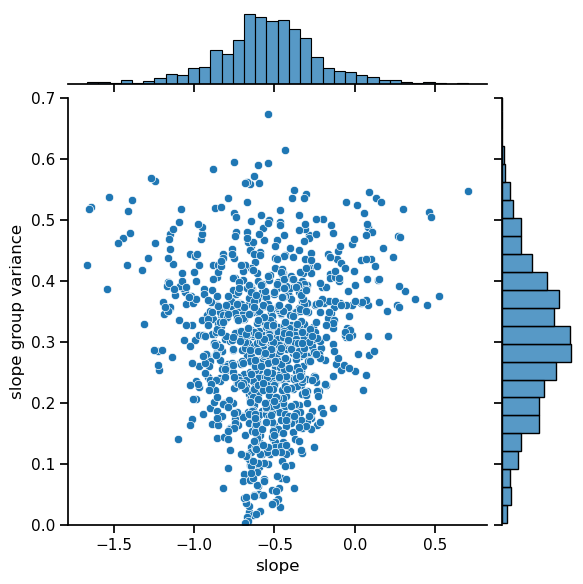

In [43]:
x = noncentered_trace.posterior['beta'].sel(chain=0, county='AITKIN').to_series() 
x.name='slope'
y = noncentered_trace.posterior['sigma_b'].sel(chain=0).to_series()
y.name='slope group variance'

jp = sns.jointplot(x=x, y=y, ylim=(0, .7));

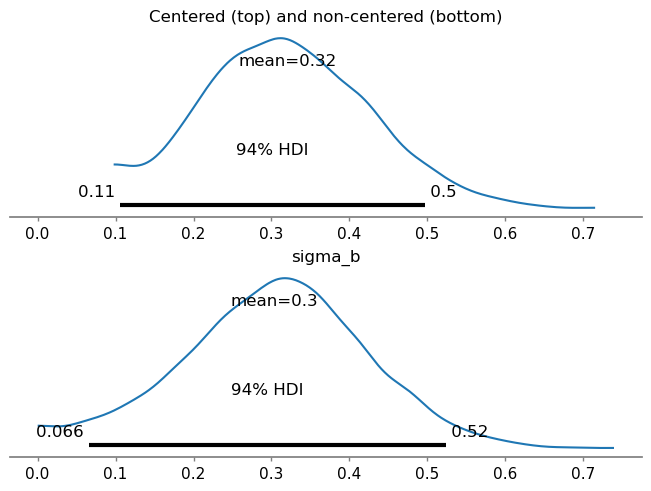

In [44]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, constrained_layout=True)
az.plot_posterior(varying_slope_trace, var_names=['sigma_b'], ax=ax1)
az.plot_posterior(noncentered_trace, var_names=['sigma_b'], ax=ax2)
ax1.set_title('Centered (top) and non-centered (bottom)');

## Varying intercept and slope model

The most general model allows both the intercept and slope to vary by county:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$


In [45]:
with pm.Model(coords=coords) as varying_intercept_slope:
    
    # Priors
    mu_a = pm.Normal('mu_a', mu=0., sigma=1e5)
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    
    mu_b = pm.Normal('mu_b', mu=0., sigma=1e5)
    sigma_b = pm.HalfCauchy('sigma_b', 5)
    
    # Random intercepts
    mu = pm.Normal('mu', mu=mu_a, sigma=sigma_a, dims='county')
    # Random slopes
    beta = pm.Normal('beta', mu=mu_b, sigma=sigma_b, dims='county')
    
    # Model error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    
    # Expected value
    y_hat = mu[county] + beta[county] * floor_measure
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon)

In [46]:
with varying_intercept_slope:
    varying_intercept_slope_trace = pm.sample(tune=4000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_a, sigma_a, mu_b, sigma_b, mu, beta, sigma_y]


Output()

Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 13 seconds.
There were 47 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


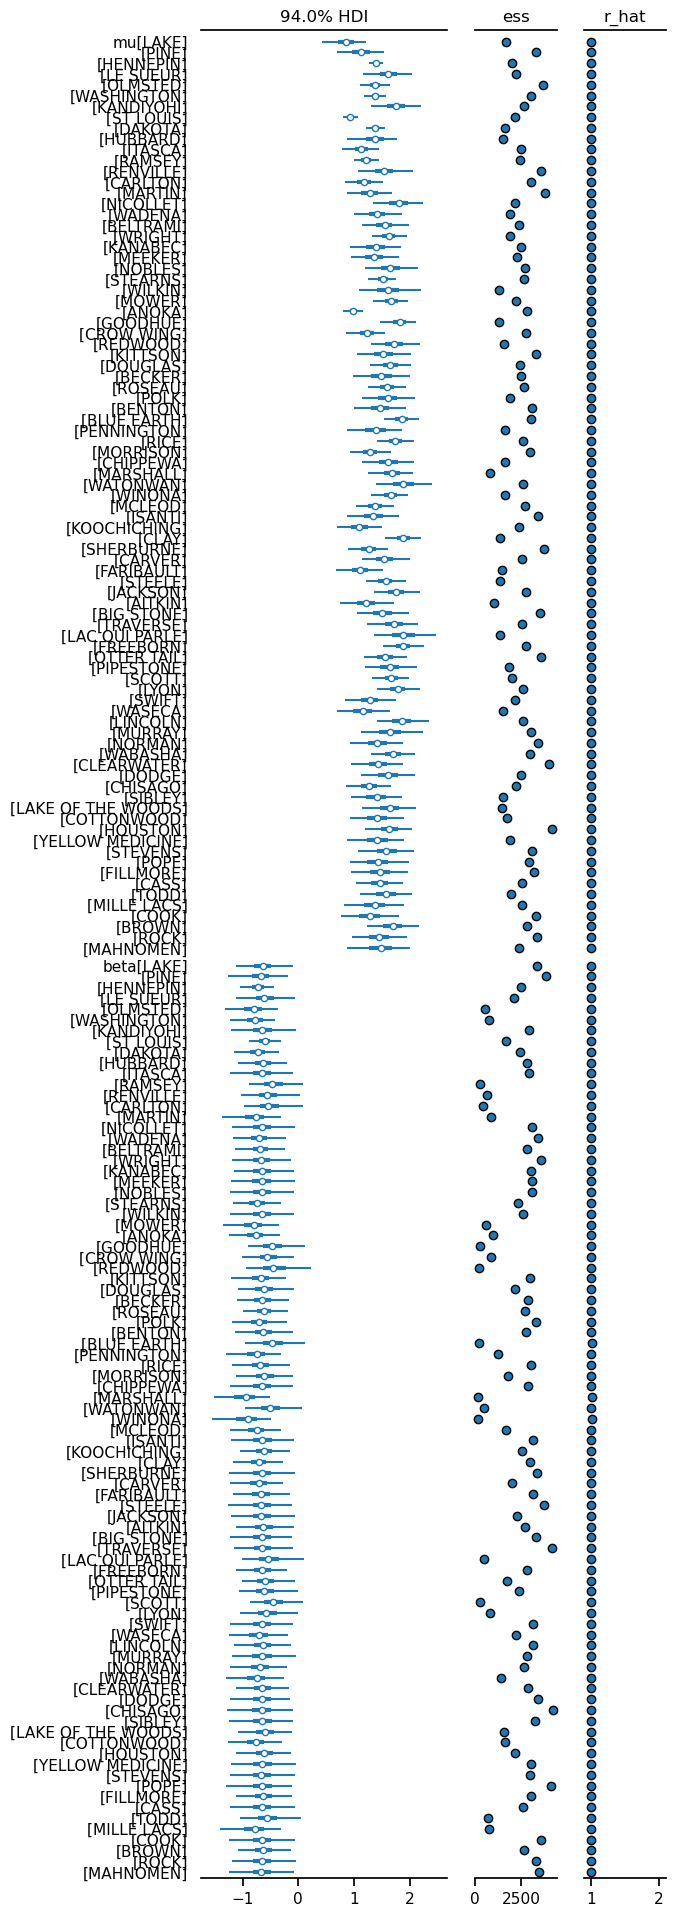

In [47]:
az.plot_forest(varying_intercept_slope_trace, var_names=['mu','beta'], figsize=(6,24), combined=True, ess=True, r_hat=True);

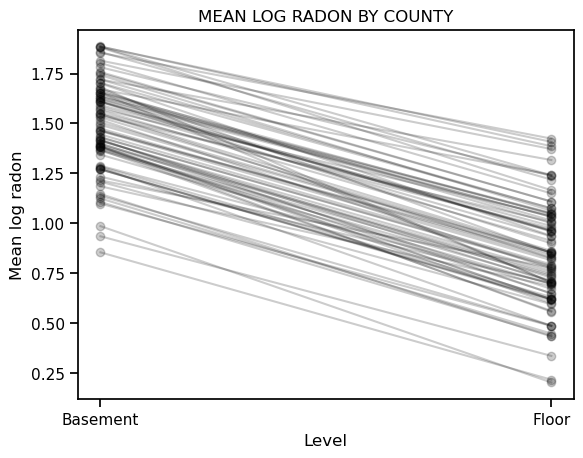

In [48]:
import xarray as xr

xvals = xr.DataArray([0, 1], dims="Level", coords={"Level": ["Basement", "Floor"]})
post = varying_intercept_slope_trace.posterior  # alias for readability
theta = (
    (post.mu + post.beta * xvals).mean(dim=("chain", "draw")).to_dataset(name="Mean log radon")
)

_, ax = plt.subplots()
theta.plot.scatter(x="Level", y="Mean log radon", alpha=0.2, color="k", ax=ax)  # scatter
ax.plot(xvals, theta["Mean log radon"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("MEAN LOG RADON BY COUNTY");

### Exercise

Reparameterize the `varying_intercept_slope` model to be non-centered, and compare the resulting parameter estimates.

In [ ]:
with pm.Model(coords=coords) as varying_intercept_slope_noncentered:
    # Write model here
    
    varying_slope_noncentered_trace = pm.sample(random_seed=RANDOM_SEED)


## Adding group-level predictors

A primary strength of multilevel models is the ability to handle predictors on multiple levels simultaneously. If we consider the varying-intercepts model above:

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

we may, instead of a simple random effect to describe variation in the expected radon value, specify another regression model with a county-level covariate. Here, we use the county uranium reading $u_j$, which is thought to be related to radon levels:

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \zeta_j$$

$$\zeta_j \sim N(0, \sigma_{\alpha}^2)$$

Thus, we are now incorporating a house-level predictor (floor or basement) as well as a county-level predictor (uranium).

Note that the model has both indicator variables for each county, plus a county-level covariate. In classical regression, this would result in collinearity. In a multilevel model, the partial pooling of the intercepts towards the expected value of the group-level linear model avoids this.

Group-level predictors also serve to reduce group-level variation $\sigma_{\alpha}$. An important implication of this is that the group-level estimate induces stronger pooling.

In [49]:
with pm.Model(coords=coords) as hierarchical_intercept:
    
    # Priors
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    
    # County uranium model
    gamma_0 = pm.Normal('gamma_0', mu=0., sigma=1e5)
    gamma_1 = pm.Normal('gamma_1', mu=0., sigma=1e5)
    
    
    # Uranium model for intercept
    mu_a = pm.Deterministic('mu_a', gamma_0 + gamma_1*u)
    # County variation not explained by uranium
    epsilon_a = pm.Normal('epsilon_a', mu=0, sigma=1, dims='county')
    mu = pm.Deterministic('mu', mu_a + sigma_a*epsilon_a)
    
    # Common slope
    beta = pm.Normal('beta', mu=0., sigma=1e5)
    
    # Model error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    
    # Expected value
    y_hat = mu[county] + beta * floor_measure
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=log_radon)
    

In [50]:
with hierarchical_intercept:
    hierarchical_intercept_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, gamma_0, gamma_1, epsilon_a, beta, sigma_y]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 6 seconds.


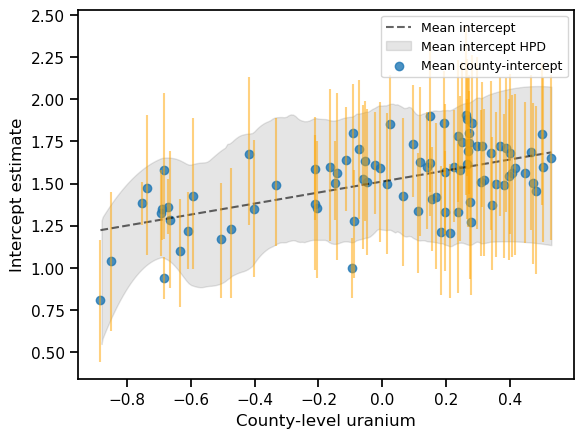

In [51]:
uranium = u
post = hierarchical_intercept_trace.posterior.assign_coords(uranium=uranium)
avg_a = post["mu_a"].mean(dim=("chain", "draw")).values[np.argsort(uranium)]
avg_a_county = post["mu"].mean(dim=("chain", "draw"))
avg_a_county_hdi = az.hdi(post, var_names="mu")["mu"]

_, ax = plt.subplots()
ax.plot(uranium[np.argsort(uranium)], avg_a, "k--", alpha=0.6, label="Mean intercept")
az.plot_hdi(
    uranium,
    post["mu"],
    fill_kwargs={"alpha": 0.1, "color": "k", "label": "Mean intercept HPD"},
    ax=ax,
)
ax.scatter(uranium, avg_a_county, alpha=0.8, label="Mean county-intercept")
ax.vlines(
    uranium,
    avg_a_county_hdi.sel(hdi="lower"),
    avg_a_county_hdi.sel(hdi="higher"),
    alpha=0.5,
    color="orange",
)
plt.xlabel("County-level uranium")
plt.ylabel("Intercept estimate")
plt.legend(fontsize=9);

The standard errors on the intercepts are narrower than for the partial-pooling model without a county-level covariate.

### Correlations among levels

In some instances, having predictors at multiple levels can reveal correlation between individual-level variables and group residuals. We can account for this by including the average of the individual predictors as a covariate in the model for the group intercept.

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \gamma_2 \bar{x} + \zeta_j$$

These are broadly referred to as ***contextual effects***.

In [52]:
# Create new variable for mean of floor across counties
xbar = srrs_mn.group_by('county').agg(pl.col('floor').mean())['floor'].to_numpy()

In [53]:
with pm.Model(coords=coords) as contextual_effect:
    
    floor_idx = pm.Data("floor_idx", floor.astype(int))
    county_idx = pm.Data("county_idx", county.astype(int))
    radon_data = pm.Data("radon_data", log_radon)
    
    # Priors
    sigma_a = pm.HalfCauchy('sigma_a', 5)
    
    # County uranium model for slope
    gamma = pm.Normal('gamma', mu=0., sigma=1e5, shape=3)
    
    # Uranium model for intercept
    mu_a = pm.Deterministic('mu_a', gamma[0] + gamma[1]*u + gamma[2]*xbar)

    # County variation not explained by uranium
    epsilon_a = pm.Normal('epsilon_a', mu=0, sigma=1, dims='county')
    mu = pm.Deterministic('mu', mu_a + sigma_a*epsilon_a)

    # Common slope
    beta = pm.Normal('beta', mu=0., sigma=1e15)
    
    # Model error
    sigma_y = pm.Uniform('sigma_y', lower=0, upper=100)
    
    # Expected value
    y_hat = mu[county_idx] + beta * floor_idx
    
    # Data likelihood
    y_like = pm.Normal('y_like', mu=y_hat, sigma=sigma_y, observed=radon_data)
    

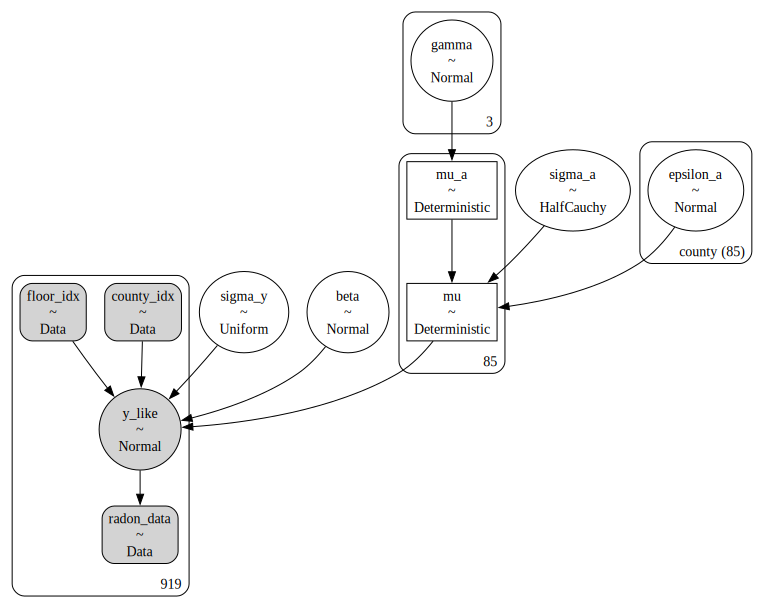

In [54]:
pm.model_to_graphviz(contextual_effect)

In [55]:
with contextual_effect:
    contextual_effect_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_a, gamma, epsilon_a, beta, sigma_y]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 6 seconds.


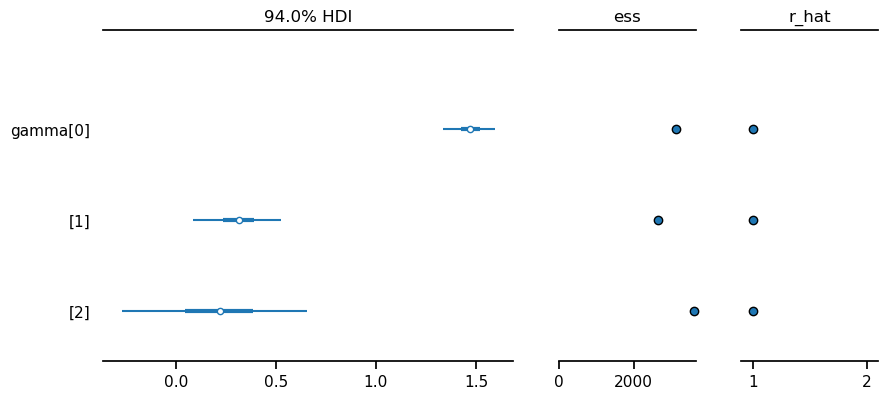

In [56]:
az.plot_forest(contextual_effect_trace, var_names=['gamma'], combined=True, ess=True, r_hat=True);

In [57]:
az.summary(contextual_effect_trace, var_names=['gamma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma[0],1.470,0.070,1.335,1.593,0.001,0.001,3153.0,2886.0,1.0
gamma[1],0.312,0.117,0.085,0.528,0.002,0.002,2721.0,2954.0,1.0
gamma[2],0.218,0.247,-0.269,0.654,0.004,0.003,3639.0,3311.0,1.0


So, we might infer from this that counties with higher proportions of houses without basements tend to have higher baseline levels of radon. Perhaps this is related to the soil type, which in turn might influence what type of structures are built.

### Prediction

Gelman (2006) used cross-validation tests to check the prediction error of the unpooled, pooled, and partially-pooled models

**root mean squared cross-validation prediction errors**:

* unpooled = 0.86
* pooled = 0.84
* multilevel = 0.79

There are two types of prediction that can be made in a multilevel model:

1. a new individual within an existing group
2. a new individual within a new group

For example, if we wanted to make a prediction for a new house with no basement in St. Louis and Kanabec counties, we just need to sample from the radon model with the appropriate intercept.

That is, 

$$\tilde{y}_i \sim N(\alpha_{69} + \beta (x_i=1), \sigma_y^2)$$

Because we judiciously set the county index and floor values as shared variables earlier, we can modify them directly to the desired values (69 and 1 respectively) and sample corresponding posterior predictions, without having to redefine and recompile our model. Using the model just above:

In [58]:
prediction_coords = {"obs_id": ["ST LOUIS", "KANABEC"]}
with contextual_effect:
    pm.set_data(
        {"county_idx": np.array([69, 31]), 
        "floor_idx": np.array([1, 1]),
        "radon_data": np.ones(2)}
    )
    stl_pred = pm.sample_posterior_predictive(
        contextual_effect_trace.posterior
    )

contextual_effect_trace.extend(stl_pred)

Sampling: [y_like]


Output()

In [59]:
contextual_effect_trace

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data
	> constant_data

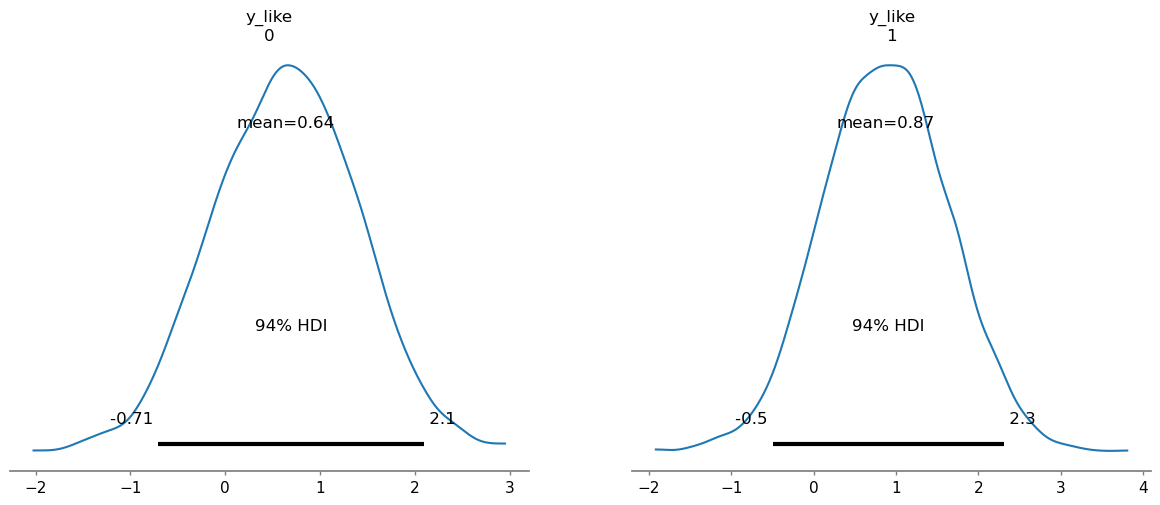

In [60]:
az.plot_posterior(contextual_effect_trace, group='posterior_predictive');

Prediction for a house within a new county is a little trickier. It is actually easier to create a new model to work with, **but use the trace from the original model for posterior predictive sampling**. 

How can this work?

First, consider how posterior predictive sampling works in PyMC: samples are drawn not from the distributions themselves, but from the set of samples in the trace. Therefore, we can take the trace from the original model, and use it to sample posterior predictions from a new model that has the same variables.

The variables in the new model need only have the same name as the original -- to reinforce this, I will use `pm.Flat` variables as placeholders in this example. The only variables we actually need are the ones that need to be resampled for a new county.

We don't even need `Data` here; we can use raw data, since we are just creating this model to get posterior predictions for houses in this notional new county.

In [61]:
with pm.Model() as new_county_house:

    # New data
    u_new = np.array([-0.2, 0.3])
    xbar = np.array([0.5, 0.8])
    floor_idx = np.array([1, 0])
    
    # Placeholders for variables already in the trace
    sigma_a = pm.Flat('sigma_a')
    gamma = pm.Flat('gamma', shape=3)
    beta = pm.Flat('beta')
    sigma_y = pm.Flat('sigma_y')

    # Calculate new county expected value
    mu_a_new = pm.Deterministic('mu_a_new', gamma[0] + gamma[1]*u_new + gamma[2]*xbar)

    # Sample from the county intercept distribution
    mu_new = pm.Normal('mu_new', mu_a_new, sigma_a)

    # Expected value for houses in new county
    y_hat_new = mu_new + beta * floor_idx
    
    y_new = pm.Normal('y_new', mu=y_hat_new, sigma=sigma_y)

    pp_new = pm.sample_posterior_predictive(contextual_effect_trace, var_names=["y_new"])

Sampling: [mu_new, y_new]


Output()

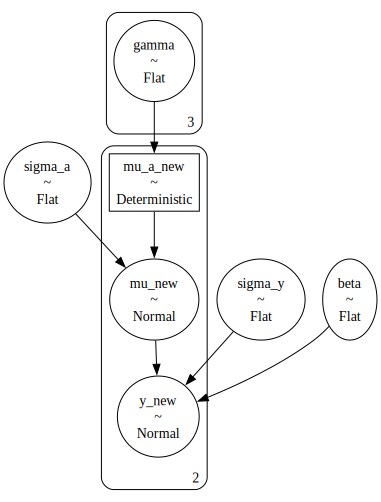

In [62]:
pm.model_to_graphviz(new_county_house)

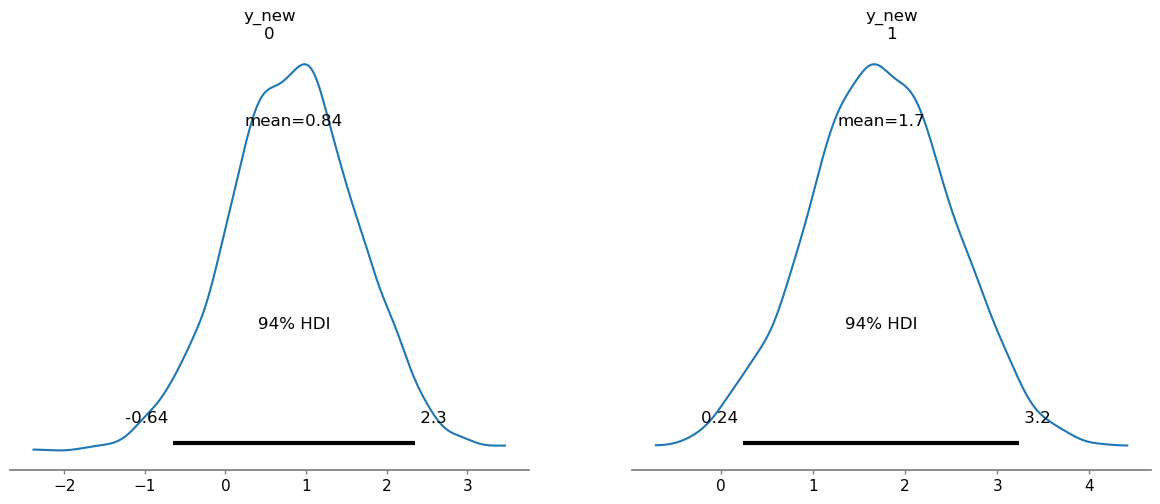

In [63]:
az.plot_posterior(pp_new, group='posterior_predictive');

## Benefits of Multilevel Models

- Accounting for natural hierarchical structure of observational data
- Estimation of coefficients for (under-represented) groups
- Incorporating individual- and group-level information when estimating group-level coefficients
- Allowing for variation among individual-level coefficients across groups


---
## References

Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.

Betancourt, M. J., & Girolami, M. (2013). Hamiltonian Monte Carlo for Hierarchical Models.

Gelman, A. (2006). Multilevel (Hierarchical) modeling: what it can and cannot do. Technometrics, 48(3), 432–435.